# Exploratory Data Analysis

**Goal** 

Explore and visualize the demographic, social, and economic structure and dynamics of Cologne over years.

## Setup & Imports

In [31]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

import seaborn as sns

import geopandas as gpd


## Load data

In [24]:
DATA_PROCESSED = Path('../data/processed/cologne_data_clean_v1.csv')

df = pd.read_csv(DATA_PROCESSED, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8892 entries, 0 to 8891
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             8892 non-null   int64  
 1   area_code                        8892 non-null   int64  
 2   area                             8892 non-null   object 
 3   area_level_code                  8892 non-null   int64  
 4   area_level                       8892 non-null   object 
 5   avg_age_total                    8879 non-null   float64
 6   avg_age_male                     8879 non-null   float64
 7   avg_age_female                   8879 non-null   float64
 8   avg_age_german                   8879 non-null   float64
 9   avg_age_non_german               8879 non-null   float64
 10  population_total                 8879 non-null   float64
 11  non_german_total                 8879 non-null   float64
 12  non_german_share    

## Filtered views

In [20]:
CITY = 0
DISTRICTS = 1
NEIGHBORHOODS = 2
STATISTICAL_BLOCKS = 3
SOCIAL_SPACES = 4

df_city = df[df.area_level_code == CITY]
df_districts = df[df.area_level_code == DISTRICTS]
df_neighborhoods = df[df.area_level_code == NEIGHBORHOODS]
df_statistical_blocks = df[df.area_level_code == STATISTICAL_BLOCKS]
df_social_spaces = df[df.area_level_code == SOCIAL_SPACES]

## Quick checks

In [8]:
latest_year = df['year'].max()
earliest_year = df['year'].min()

print(earliest_year, latest_year)

2012 2024


### Missing values (by area level)

In [19]:
df.groupby('area_level_code')[df.select_dtypes(include=["float64"]).columns].apply(lambda x: x.isna().mean()).T

area_level_code,0,1,2,3,4
avg_age_total,0.0,0.000000,0.000000,0.000000,0.055556
avg_age_male,0.0,0.000000,0.000000,0.000000,0.055556
avg_age_female,0.0,0.000000,0.000000,0.000000,0.055556
avg_age_german,0.0,0.000000,0.000000,0.000000,0.055556
avg_age_non_german,0.0,0.000000,0.000000,0.000000,0.055556
population_total,0.0,0.000000,0.000000,0.000000,0.055556
non_german_total,0.0,0.000000,0.000000,0.000000,0.055556
non_german_share,0.0,0.000000,0.000000,0.000000,0.055556
migration_background_total,0.0,0.000000,0.000000,0.000000,0.055556
migration_background_share,0.0,0.000000,0.000000,0.000000,0.055556


Most indicators are fully available at city, district, and neighborhood level, while statistical blocks and social spaces show substantial structural missingness. In this project I focus on city (trends) and districts (comparisons).

In [9]:
df_districts.groupby('year')[['new_registered_electric_cars', 'registered_electric_cars']].apply(lambda x: x.isna().mean())

,new_registered_electric_cars,registered_electric_cars
year,,
2012,0.222222,0.222222
2013,0.333333,0.222222
2014,0.444444,0.111111
2015,0.555556,0.000000
2016,0.222222,0.000000
2017,0.000000,0.000000
2018,0.000000,0.000000
2019,0.000000,0.000000
2020,0.000000,0.000000


#### Co-missingness

In [13]:
# df.isna().corr()

### Duplicates

In [14]:
df.duplicated(subset=['year','area_code']).sum()

np.int64(0)

## Area Levels & Coverage

The dataset is hierarchical and covers multiple administrative levels of Cologne.
Each row represents one area in one year.

Gesamtstadt	(0) - Entire city 

Stadtbezirke (1) - 9 Districts  

Stadtteile (2) - 86 Neighborhoods 

Statistische Quartiere (3) - 570 Statistical blocks

Sozialräume (4) - 18 Social spaces

In [21]:
df['area_level'].value_counts()

area_level
Statistische Quartiere    7410
Stadtteile                1118
Sozialräume                234
Stadtbezirke               117
Gesamtstadt                 13
Name: count, dtype: int64

In [22]:
df.groupby(['year', 'area_level']).size().unstack(fill_value=0)

area_level,Gesamtstadt,Sozialräume,Stadtbezirke,Stadtteile,Statistische Quartiere
year,,,,,
2012,1,18,9,86,570
2013,1,18,9,86,570
2014,1,18,9,86,570
2015,1,18,9,86,570
2016,1,18,9,86,570
2017,1,18,9,86,570
2018,1,18,9,86,570
2019,1,18,9,86,570
2020,1,18,9,86,570


## Spatial structure

In [28]:
GEO_DIR = Path('../data/geo')
SHAPE_DISTRICTS = GEO_DIR / 'Stadtbezirk/Stadtbezirk.shp'
SHAPE_NEIGHBORHOODS = GEO_DIR / 'Stadtteil/Stadtteil.shp'
SHAPE_STAT_BLOCKS = GEO_DIR / 'Statistisches_Quartier/Statistisches_Quartier.shp'

In [32]:
gdf_d = gpd.read_file(SHAPE_DISTRICTS)
gdf_n = gpd.read_file(SHAPE_NEIGHBORHOODS)
gdf_sb = gpd.read_file(SHAPE_STAT_BLOCKS)

Quick look

In [ ]:
gdf_d.columns, gdf_d.head(2), gdf_d.crs # The Coordinate Reference System

(Index(['nummer', 'name', 'flaeche', 'geometry'], dtype='object'),
   nummer          name       flaeche  \
 0      1    Innenstadt  1.640542e+07   
 1      2  Rodenkirchen  5.459151e+07   
 
                                             geometry  
 0  POLYGON ((358932.01 5644491.24, 358929.245 564...  
 1  POLYGON ((355322.362 5643194.433, 355334.268 5...  ,
 <Projected CRS: EPSG:25832>
 Name: ETRS89 / UTM zone 32N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Europe between 6°E and 12°E: Austria; Denmark - onshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore; Spain - offshore.
 - bounds: (6.0, 36.53, 12.01, 84.01)
 Coordinate Operation:
 - name: UTM zone 32N
 - method: Transverse Mercator
 Datum: European Terrestrial Reference System 1989 ensemble
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich)

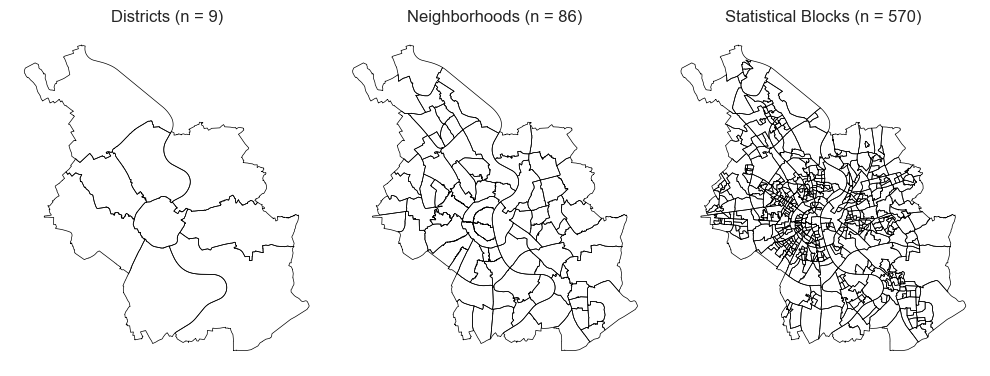

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(10,5))

gdf_d.plot(ax=axes[0], edgecolor='black', facecolor='none', linewidth=0.5)
axes[0].set_title(f'Districts (n = {len(gdf_d)})')
axes[0].set_axis_off()

gdf_n.plot(ax=axes[1], edgecolor='black', facecolor='none', linewidth=0.5)
axes[1].set_title(f'Neighborhoods (n = {len(gdf_n)})')
axes[1].set_axis_off()

gdf_sb.plot(ax=axes[2], edgecolor='black', facecolor='none', linewidth=0.5)
axes[2].set_title(f'Statistical Blocks (n = {len(gdf_sb)})')
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

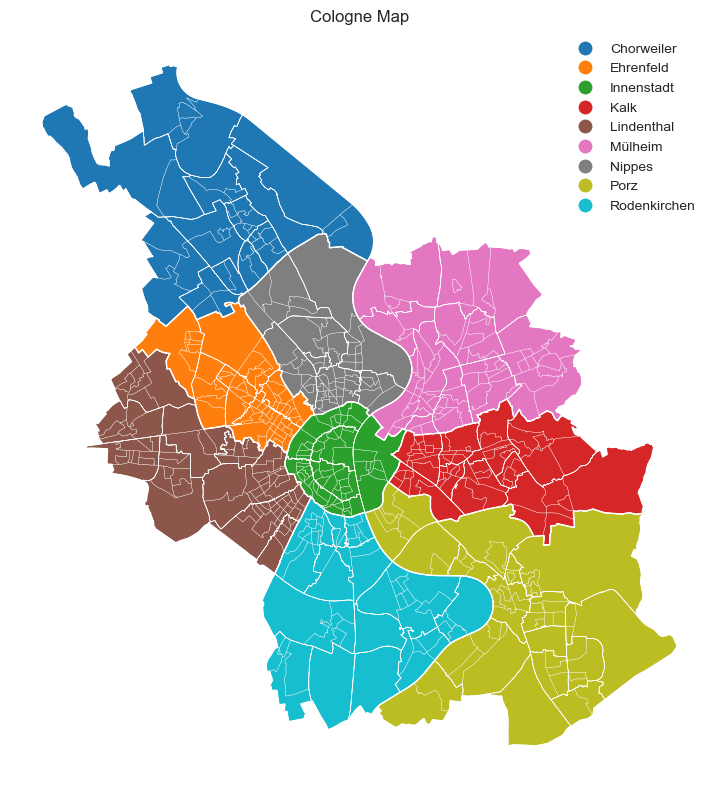

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

gdf_d.plot(ax=ax, edgecolor='white', column='name', categorical=True, cmap='tab10', linewidth=1, legend=True)
gdf_n.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=0.5)
gdf_sb.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=0.2)

ax.set_title("Cologne Map")
ax.set_axis_off()
plt.tight_layout()
plt.show()